In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import plotly.plotly as py
import plotly.graph_objs as go
from ipywidgets import interact

from bokeh.io import output_file, show, output_notebook, curdoc, push_notebook
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, Select,FixedTicker, PrintfTickFormatter, \
Legend, DatetimeTickFormatter, CrosshairTool
from bokeh.models.widgets import Select, Tabs, Panel, Slider, TextInput, DateRangeSlider, RangeSlider
from bokeh.models.glyphs import VBar
from bokeh.layouts import column, row
from bokeh.palettes import Category10, Category20, Inferno
import colorcet as cc
import seaborn as sns
from numpy import linspace
from scipy.stats.kde import gaussian_kde


import datetime
%load_ext blackcellmagic
%matplotlib inline

## Refs
https://www.bmreports.com/bmrs/?q=actgenration/actualgeneration
http://energynumbers.info/uk-offshore-wind-capacity-factors
http://www.ukenergywatch.org/powerstations

# Gridwatch - Nuclear vs Wind

In [2]:
data12 = pd.read_csv('gridwatchNucVsWind.csv', index_col=1,skip_blank_lines=True, header=[0], parse_dates=True)
#data10.drop('Belgium-UK',1,level=0,inplace=True)
data12.head()


,id,demand,nuclear,wind
timestamp,,,,
2011-05-27 15:50:04,4,38874,8221,1253
2011-05-27 15:55:02,5,38845,8225,1304
2011-05-27 16:00:02,6,38745,8224,1322
2011-05-27 16:05:01,7,38826,8220,1364
2011-05-27 16:10:02,8,38865,8210,1370


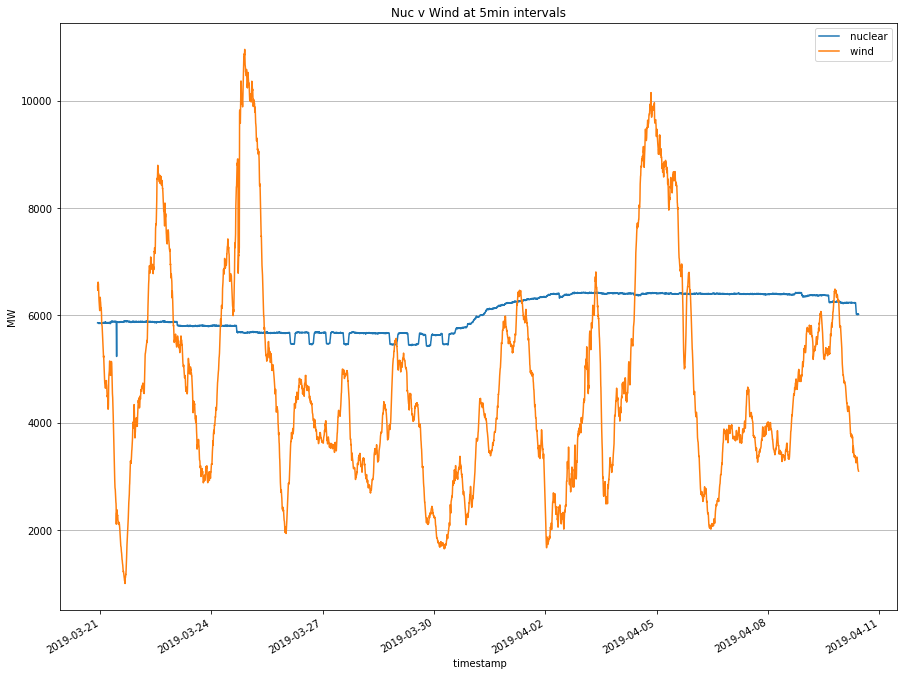

In [3]:
fig=plt.figure(figsize = [15,12])
ax = fig.add_subplot(111)
#ax.xaxis.set(ticks=range(0,data12.shape[0],12))
#ax.set_ylim([0,60000])
#colsToUse = [' demand',' nuclear',' wind']
ax.set(title= 'Nuc v Wind at 5min intervals',\
       ylabel = 'MW', xlabel='Time')
data12.iloc[820000:,[2,3]].plot(ax=ax)     
ax.grid(True, axis='y')
plt.legend()
#for col in colsToUse:
 #   plt.text(data12.shape[0], float(data12[col][-1]),col)

In [4]:
data12.loc['2013-05-15']#=='2011-05-27'
newting = data12.groupby(data12.index.hour).mean()
newting
data12['Hour'] = data12.index.hour
data12['Min'] = data12.index.minute
data12['DayHour'] = data12['Hour'] + data12['Min']/60
data12['Year'] = data12.index.year
data12[data12['DayHour']==1.5].head()
data12['Month'] = data12.index.month
data12['Day'] = data12.index.day

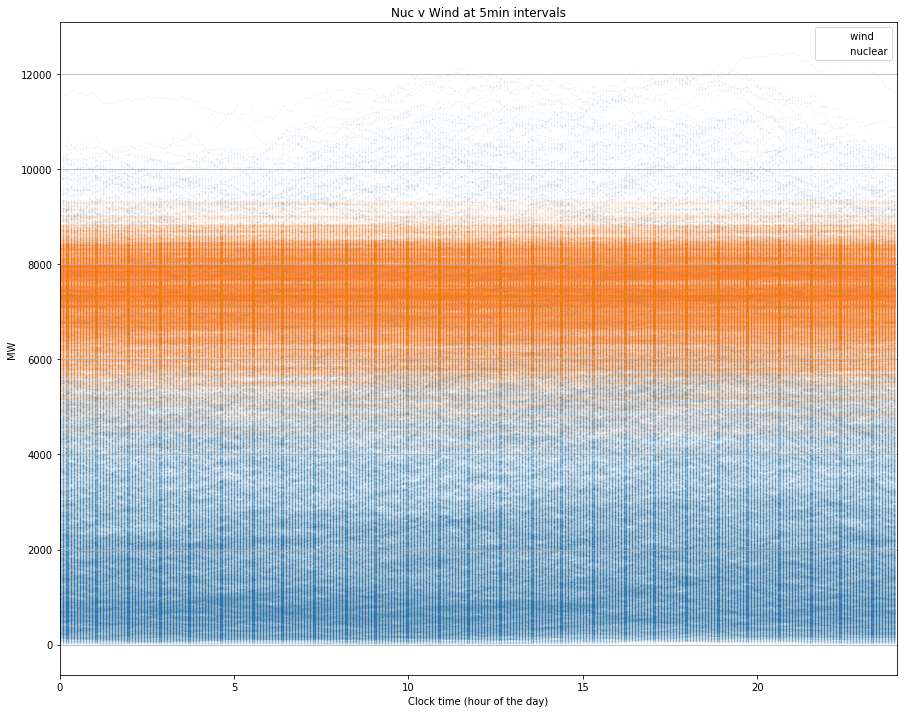

In [5]:
fig=plt.figure(figsize = [15,12])
ax = fig.add_subplot(111)
#ax.xaxis.set(ticks=range(0,data12.shape[0]))#,int(data12.shape[0]/24)))
ax.set_xlim([0,24])
#colsToUse = [' demand',' nuclear',' wind']
ax.set(title= 'Nuc v Wind at 5min intervals',\
       ylabel = 'MW', xlabel='Clock time (hour of the day)')
ax.scatter(data12.iloc[:,6], data12.iloc[:,3], alpha=0.05, s=1) 
ax.scatter(data12.iloc[:,6], data12.iloc[:,2], alpha=0.05, s=1)
ax.grid(True, axis='y')
plt.legend()
#for col in colsToUse:
 #   plt.text(data12.shape[0], float(data12[col][-1]),col)

In [6]:
# plotly doesn't like all that data

#trace1 = go.Scatter(x=data12.iloc[:,6], y=data12.iloc[:,3])
#trace2 = go.Scatter(x=data12.iloc[:,6], y=data12.iloc[:,2])

#data = [trace1, trace2]
#py.iplot(data)

In [7]:
print(data12.head())
data121 = data12.reset_index()
print(data121.head())
print(data121.columns)
data121melted = pd.melt(data121.drop([' demand',' timestamp','Min','DayHour','Year'],axis=1),
                        id_vars=['Hour','id'],
                        var_name='Label')
data121melted.head()

                     id   demand   nuclear   wind  Hour  Min    DayHour  Year  \
 timestamp                                                                      
2011-05-27 15:50:04   4    38874      8221   1253    15   50  15.833333  2011   
2011-05-27 15:55:02   5    38845      8225   1304    15   55  15.916667  2011   
2011-05-27 16:00:02   6    38745      8224   1322    16    0  16.000000  2011   
2011-05-27 16:05:01   7    38826      8220   1364    16    5  16.083333  2011   
2011-05-27 16:10:02   8    38865      8210   1370    16   10  16.166667  2011   

                     Month  Day  
 timestamp                       
2011-05-27 15:50:04      5   27  
2011-05-27 15:55:02      5   27  
2011-05-27 16:00:02      5   27  
2011-05-27 16:05:01      5   27  
2011-05-27 16:10:02      5   27  
            timestamp  id   demand   nuclear   wind  Hour  Min    DayHour  \
0 2011-05-27 15:50:04   4    38874      8221   1253    15   50  15.833333   
1 2011-05-27 15:55:02   5    38845      

,Hour,id,Label,value
0,15,4,nuclear,8221
1,15,5,nuclear,8225
2,16,6,nuclear,8224
3,16,7,nuclear,8220
4,16,8,nuclear,8210


In [8]:
def nowtime():
    now=datetime.datetime.now()
    return "".join([str(i) for i in (now.day,0,now.month,now.year,now.hour,now.minute)])

In [9]:
# Now try with Bokeh!

fig = figure(plot_width=900, plot_height=700,title='Nuc v Wind with Bokeh',
            x_axis_type='datetime')

dataSource = ColumnDataSource(data121)
ylist = [' wind',' nuclear']
colRef = 0
for line in ylist:
    colRef += 1
    lines = fig.circle(x='DayHour', y=line, source=dataSource, 
                     color = Category20[(len(ylist)+1)][colRef],
                      size=0.3, fill_alpha=0.005)
    
    
    #line_width=1) 
    #hover = HoverTool(tooltips =[('Cat',line),('MW','$y')], renderers=[lines])
    #fig.add_tools(hover)

#output_notebook()
show(fig)

In [87]:
data121.head()

,timestamp,id,demand,nuclear,wind,Hour,Min,DayHour,Year,Month,Day
0,2011-05-27 15:50:04,4,38874,8221,1253,15,50,15.833333,2011,5,27
1,2011-05-27 15:55:02,5,38845,8225,1304,15,55,15.916667,2011,5,27
2,2011-05-27 16:00:02,6,38745,8224,1322,16,0,16.000000,2011,5,27
3,2011-05-27 16:05:01,7,38826,8220,1364,16,5,16.083333,2011,5,27
4,2011-05-27 16:10:02,8,38865,8210,1370,16,10,16.166667,2011,5,27


In [10]:
# Plot demand IN ONE DAY/WEEK/MONTH with Bokeh

dataLength = 'month'

output_file("C:/Users/Chris/Documents/Documents/Python2018/DataVisCW/Plots/DemandLine"+nowtime()+".html")
fig = figure(plot_width=1200, plot_height=600,
             title='UK electricity demand throughout one '+dataLength,
            x_axis_type='datetime', toolbar_location="above")

pts = len(data121)
daySlot = 24*12 # number of data points (5min periods) in 24hrs
weekSlot = 7*daySlot
monthSlot = 30*daySlot

tooltips = []#('Demand','@{ demand}{( 0,0)}MW')]
if dataLength == 'month':
    slot, space = monthSlot, 12
    tooltips.insert(0,('Time','@{ timestamp}{%H:%M}'))
    tooltips.insert(1,('Date','@{ timestamp}{%a %e-%b}'))
elif dataLength == 'week':
    slot,space = weekSlot, 3
    tooltips.insert(0,('Time','@{ timestamp}{%H:%M}'))
    tooltips.insert(1,('Date','@{ timestamp}{%a %e-%b}'))
elif dataLength == 'day':
    slot,space = daySlot, 1
    tooltips.insert(0,('Time','@{ timestamp}{%H:%M}'))

    
dataSource = ColumnDataSource(data121.iloc[-slot::space,:])

ylist = [' demand',' nuclear', ' wind']
legend=[]
for colRef,line in enumerate(ylist,1):
    lines = fig.line(x=' timestamp', y=line, source=dataSource, 
                     color = Category10[(len(ylist)+2)][colRef],
                    line_width=2) 
    #legend.append((str(ylist[colRef-1])+' ',[lines]))
    tips2 = [(line[1:].capitalize(),'@{'+line+'}{( 0,0)}MW')]
    if line == ' demand':
        tips2 = list(set(tips2+tooltips))
    hover2 = HoverTool(tooltips =tips2, 
                      formatters={' timestamp': 'datetime'},
                      renderers=[lines], toggleable=False,
                     mode='vline')
    
    fig.add_tools(hover2)
    #hover = HoverTool(tooltips =tooltips, 
      #                formatters={' timestamp': 'datetime'},
                      #renderers=[lines], 
       #               toggleable=False, mode='vline')
    #if line == ' demand':
#    fig.add_tools(hover)    
fig.add_tools(CrosshairTool(dimensions='height'))
                        #plot.add_tools(BoxSelectTool(dimensions="width"))
#daySlider = Slider(start=0, end=10, value=1, step=1, title="dayShunt")

#def update_data(name, old, new):
#    a = daySlider.value
#    dataSource = ColumnDataSource(data121.iloc[(pts-(a+1)*slot):
#                                               (pts-(a)*slot):
#                                               space,:])
#daySlider.on_change('value', update_data)
    
    
#legend = Legend(items=legend, location='center')
#fig.add_layout(legend, 'right')
#fig.legend.click_policy="hide"

fig.outline_line_color = None
fig.background_fill_color = "#efefef"

#fig.xaxis.ticker = FixedTicker(ticks=list(range(0, xmax,1000)))

#fig.ygrid.grid_line_color = None
#fig.xgrid.grid_line_color = "#dddddd"
#fig.xgrid.ticker = fig.xaxis[0].ticker
fig.y_range.start=0
fig.xaxis.minor_tick_line_color = 'black'
fig.xaxis.formatter = DatetimeTickFormatter(days = [ '%a %e-%b'], hours=['%R'])

#fig.axis.major_tick_line_color = None
fig.axis.axis_line_color = 'black'
#fig.yaxis.axis_label = 'Total electricity supplied in Quarter (TWh)'

#inputs = column(daySlider)
#curdoc().add_root(row(inputs, fig, width=800))
#curdoc().title = "DemandInADay"
output_notebook()

show(fig)


Loading BokehJS ...

In [11]:
tooltips

[('Time', '@{ timestamp}{%H:%M}'), ('Date', '@{ timestamp}{%a %e-%b}')]

In [12]:
# Plot demand IN ONE WEEK with Bokeh

dataLength = 'week'

output_file("C:/Users/Chris/Documents/Documents/Python2018/DataVisCW/Plots/DemandLine"+nowtime()+".html")
fig = figure(plot_width=1200, plot_height=600,
             title='UK electricity demand throughout one '+dataLength,
            x_axis_type='datetime', toolbar_location="above")

pts = len(data121)
daySlot = 24*12 # number of data points (5min periods) in 24hrs
weekSlot = 7*daySlot
monthSlot = 30*daySlot
if dataLength == 'month':
    slot, space = monthSlot, 12
elif dataLength == 'week':
    slot,space = weekSlot, 3
elif dataLength == 'day':
    slot,space = daySlot, 1

dataSource = ColumnDataSource(data121.iloc[-slot::space,:])

ylist = [' demand']
legend=[]
for colRef,line in enumerate(ylist,1):
    lines = fig.line(x=' timestamp', y=line, source=dataSource, 
                     color = Category10[(len(ylist)+2)][colRef],
                    line_width=2) 
    #legend.append((str(ylist[colRef-1])+' ',[lines]))
    hover = HoverTool(tooltips =[('Date','@{ timestamp}{%a%e-%b}'),
                                 ('Time','@{ timestamp}{%H:%M}'),
                                 ('Demand','@{ demand}{( 0,0)}MW')], 
                      formatters={' timestamp': 'datetime'},
                      renderers=[lines], toggleable=False,
                     mode='vline')
    fig.add_tools(hover)

#daySlider = Slider(start=0, end=10, value=1, step=1, title="dayShunt")

#def update_data(name, old, new):
#    a = daySlider.value
#    dataSource = ColumnDataSource(data121.iloc[(pts-(a+1)*slot):
#                                               (pts-(a)*slot):
#                                               space,:])
#daySlider.on_change('value', update_data)
    
    
#legend = Legend(items=legend, location='center')
#fig.add_layout(legend, 'right')
#fig.legend.click_policy="hide"

fig.outline_line_color = None
fig.background_fill_color = "#efefef"

#fig.xaxis.ticker = FixedTicker(ticks=list(range(0, xmax,1000)))

#fig.ygrid.grid_line_color = None
#fig.xgrid.grid_line_color = "#dddddd"
fig.xaxis.formatter = DatetimeTickFormatter(days = [ '%a%e-%b'])


fig.xaxis.minor_tick_line_color = 'black'

#fig.axis.major_tick_line_color = None
fig.axis.axis_line_color = 'black'
#fig.yaxis.axis_label = 'Total electricity supplied in Quarter (TWh)'

#inputs = column(daySlider)
#curdoc().add_root(row(inputs, fig, width=800))
#curdoc().title = "DemandInADay"
output_notebook()

show(fig)


Loading BokehJS ...

In [13]:
#! bokeh serve --show daySliders.py

In [14]:
# MAKE TABS

# Create two panels, one for each conference
#east_panel = Panel(child=east_fig, title='Eastern Conference')
#west_panel = Panel(child=west_fig, title='Western Conference')

# Assign the panels to Tabs
#tabs = Tabs(tabs=[west_panel, east_panel])

# Show the tabbed layout
#show(tabs)

In [15]:
data121.dtypes

 timestamp    datetime64[ns]
id                     int64
 demand                int64
 nuclear               int64
 wind                  int64
Hour                   int64
Min                    int64
DayHour              float64
Year                   int64
Month                  int64
Day                    int64
dtype: object

In [16]:
data121[' timestamp'][:10]

0   2011-05-27 15:50:04
1   2011-05-27 15:55:02
2   2011-05-27 16:00:02
3   2011-05-27 16:05:01
4   2011-05-27 16:10:02
5   2011-05-27 16:15:01
6   2011-05-27 16:20:02
7   2011-05-27 16:25:04
8   2011-05-27 16:30:03
9   2011-05-27 16:35:01
Name:  timestamp, dtype: datetime64[ns]

# Bokeh ridge plot

In [17]:
data122 = data121.drop(' timestamp', axis=1)
data122.head()

,id,demand,nuclear,wind,Hour,Min,DayHour,Year,Month,Day
0,4,38874,8221,1253,15,50,15.833333,2011,5,27
1,5,38845,8225,1304,15,55,15.916667,2011,5,27
2,6,38745,8224,1322,16,0,16.000000,2011,5,27
3,7,38826,8220,1364,16,5,16.083333,2011,5,27
4,8,38865,8210,1370,16,10,16.166667,2011,5,27


In [18]:
def nowtime():
    now=datetime.datetime.now()
    return "".join([str(i) for i in (now.day,0,now.month,now.year,now.hour,now.minute)])

In [19]:
## The one that works for just nuclear ##

output_file("plots/ridgeplot"+nowtime()+".html")

def ridge(category, data, scale=800):
    return list(zip([category]*len(data), scale*data))

years = data122['Year'].unique()
print(years, type(years[0]))
palette = [cc.rainbow[i*15] for i in range(len(years)+1)]

x = linspace(-20,data122[' nuclear'].max(),500)

source = ColumnDataSource(data=dict(x=x))
p = figure(plot_width=900,y_range=[str(year) for year in years], 
            x_range=(-5, data122[' nuclear'].max()), 
            toolbar_location=None)

for i, year in enumerate(years,1):
    
    print(i,year)
    pdf = gaussian_kde(data122[data122['Year']==year].loc[:,' nuclear'].reset_index(drop=True))
    y = ridge(str(year), pdf(x))
    source.add(y, str(year))
    p.patch(x='x', y=str(year), color=palette[i], 
            alpha=0.6, line_color="black", source=source)

    
p.outline_line_color = None
p.background_fill_color = "#efefef"

p.xaxis.ticker = FixedTicker(ticks=list(range(0, data122[' nuclear'].max(),1000)))

p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis[0].ticker

p.axis.minor_tick_line_color = None
p.axis.major_tick_line_color = None
p.axis.axis_line_color = None

p.y_range.range_padding = 0.12

show(p)


[2011 2012 2013 2014 2015 2016 2017 2018 2019] <class 'numpy.int64'>
1 2011
2 2012
3 2013
4 2014
5 2015
6 2016
7 2017
8 2018
9 2019


In [20]:
## TWIN RIDGE PLOT ##
from bokeh.palettes import *
from matplotlib.colors import *
output_file("plots/twinridgeplot"+nowtime()+".html")

def ridge(category, data, scale=800):
    return list(zip([category]*len(data), scale*data))

years = data122['Year'].unique()
print(years, type(years[0]))
palette1 = Blues[len(years)]#[cc.kg[i*15] for i in range(len(years)+1)]
palette2 = OrRd[len(years)]#[cc.kb[i*15] for i in range(len(years)+1)]

xmin,xmax,num = 0,max(data122[[' nuclear',' wind']].max()),500
x = linspace(xmin,xmax,num)
xnew = list(x)
xnew.insert(0,xmin - (xmax-xmin)/num)
xnew.append(xmax + (xmax-xmin)/num)
source = ColumnDataSource(data=dict(xnew=xnew))
source2 = ColumnDataSource(data=dict(xnew=xnew))

p = figure(plot_width=900,y_range=[str(year) for year in reversed(years)], 
            x_range=(-5, xmax),title='Ridge plot with KDE')#,toolbar_location=None)

for i, year in enumerate(reversed(years),1):
    
    print(i,year)
    pdf = gaussian_kde(data122[data122['Year']==year].loc[:,' nuclear'].reset_index(drop=True))
    y = ridge(str(year), pdf(x))
    y.insert(0,(str(year),0))
    y.append((str(year),0))
    source.add(y, str(year))
    
    pdf2 = gaussian_kde(data122[data122['Year']==year].loc[:,' wind'].reset_index(drop=True))
    y2 = ridge(str(year), pdf2(x))
    y2.insert(0,(str(year),0))
    y2.append((str(year),0))
    source2.add(y2, str(year))
    p.patch(x='xnew', y=str(year), color=palette1[i-1], 
            alpha=0.6, line_color="black",
            source=source)
    p.patch(x='xnew', y=str(year),
           color=palette2[i-1], 
           alpha=0.6, line_color="black", 
           source=source2)
    
p.outline_line_color = None
p.background_fill_color = "#efefef"

p.xaxis.ticker = FixedTicker(ticks=list(range(0, xmax,1000)))

p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis[0].ticker

p.axis.minor_tick_line_color = None
p.axis.major_tick_line_color = None
p.axis.axis_line_color = None

p.y_range.range_padding = 0.2

show(p)


[2011 2012 2013 2014 2015 2016 2017 2018 2019] <class 'numpy.int64'>
1 2019
2 2018
3 2017
4 2016
5 2015
6 2014
7 2013
8 2012
9 2011


In [21]:
## TWIN RIDGE PLOT - NOT KDE ##
#from bokeh.palettes import *
from matplotlib.colors import *
output_file("plots/twinridgeplot"+nowtime()+".html")

def ridge(category, data, scale=800):
    return list(zip([category]*len(data), scale*data))

years = data122['Year'].unique()
print(years, type(years[0]))
palette1 = [cc.kr[i*15+100] for i in range(len(years)+1)]
palette2 = [cc.kb[i*15+100] for i in range(len(years)+1)]

xmin,xmax,num = 0,max(data122[[' nuclear',' wind']].max()),500
x = linspace(xmin,xmax,num)
xnew = list(x)
xnew.insert(0,xmin - (xmax-xmin)/num)
xnew.append(xmax + (xmax-xmin)/num)
source = ColumnDataSource(data=dict(xnew=xnew))
source2 = ColumnDataSource(data=dict(xnew=xnew))

p = figure(plot_width=900,y_range=[str(year) for year in reversed(years)], 
            x_range=(-5, xmax),#,toolbar_location=None)
           title = 'Histogram showing power output for each 5min interval throughout the year')


for i, year in enumerate(reversed(years)):
    print(i)
    hist, edges = np.histogram(data122[data122['Year']==year].loc[:,' nuclear'].reset_index(drop=True),
                               density=True, bins=200, range=(0,xmax))
    hist2, edges2 = np.histogram(data122[data122['Year']==year].loc[:,' wind'].reset_index(drop=True),
                               density=True, bins=200, range=(0,xmax))
    scaler = 1/ (1000*np.max([np.max(hist),np.max(hist2)]))
    y = ridge(str(year), hist)#*scaler)
    y2 = ridge(str(year), hist2)#*scaler)

    p.quad(top=y, bottom=((str(year),0),)*len(y), left=edges[:-1], right=edges[1:],
           fill_color=palette1[9-i], line_color="gray", alpha=0.5, legend='Nuclear')
    p.quad(top=y2, bottom=((str(year),0),)*len(y2), left=edges[:-1], right=edges[1:],
           fill_color=palette2[9-i], line_color="gray", alpha=0.5, legend='Wind')
 #  print('Sum: hist',np.sum(hist),'hist2',np.sum(hist2))
 #   print('Max: hist',np.max(hist)*1000,'hist2',np.max(hist2)*1000)
    #p.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend="PDF")
    #p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend="CDF")

    #p.y_range.start = 0
    #p.legend.location = "center_right"
    #p.legend.background_fill_color = "#fefefe"
p.xaxis.axis_label = 'Power output (MW)'

    #p.yaxis.axis_label = 'Pr(x)'
    #p.grid.grid_line_color="white"
    
    
    
p.outline_line_color = None
p.background_fill_color = "#efefef"

p.xaxis.ticker = FixedTicker(ticks=list(range(0, xmax,1000)))

p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis[0].ticker

p.axis.minor_tick_line_color = None
p.axis.major_tick_line_color = None
p.axis.axis_line_color = None

p.y_range.range_padding = 0.1



show(p)


[2011 2012 2013 2014 2015 2016 2017 2018 2019] <class 'numpy.int64'>
0
1
2
3
4
5
6
7
8


What it shows:
- Nuclear is much more concentrated i.e. predictable what output is
- Wind is spread over a huge range
- Wind capacity increasing, nuclear capacity decreasing - wind has overtaken nuclear

Difficult to be 'fair' and actually represent what the data is saying:
- Want to have as many bars to the right as possible to represent lots of periods of big power generation
- Big bars to the LHS are actually bad but they look good
- The small bars on the RHS for wind are good
- Bars to the RHS are more important than those to the RHS - the electricity generated is NOT the area under the curve

The total count of the two is the same i.e. they both have all 5min intervals in the year
The histograms plot relative to the number of days recorded in the year, so that 2019 is scaled correctly as there are only 4 months of data.

In [22]:
12*62690/(365*24*12)

7.156392694063927

In [23]:
data122[data122.loc[:,' wind']<10].count()

id          107
 demand     107
 nuclear    107
 wind       107
Hour        107
Min         107
DayHour     107
Year        107
Month       107
Day         107
dtype: int64

C:\Users\Chris\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.

C:\Users\Chris\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning:

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.



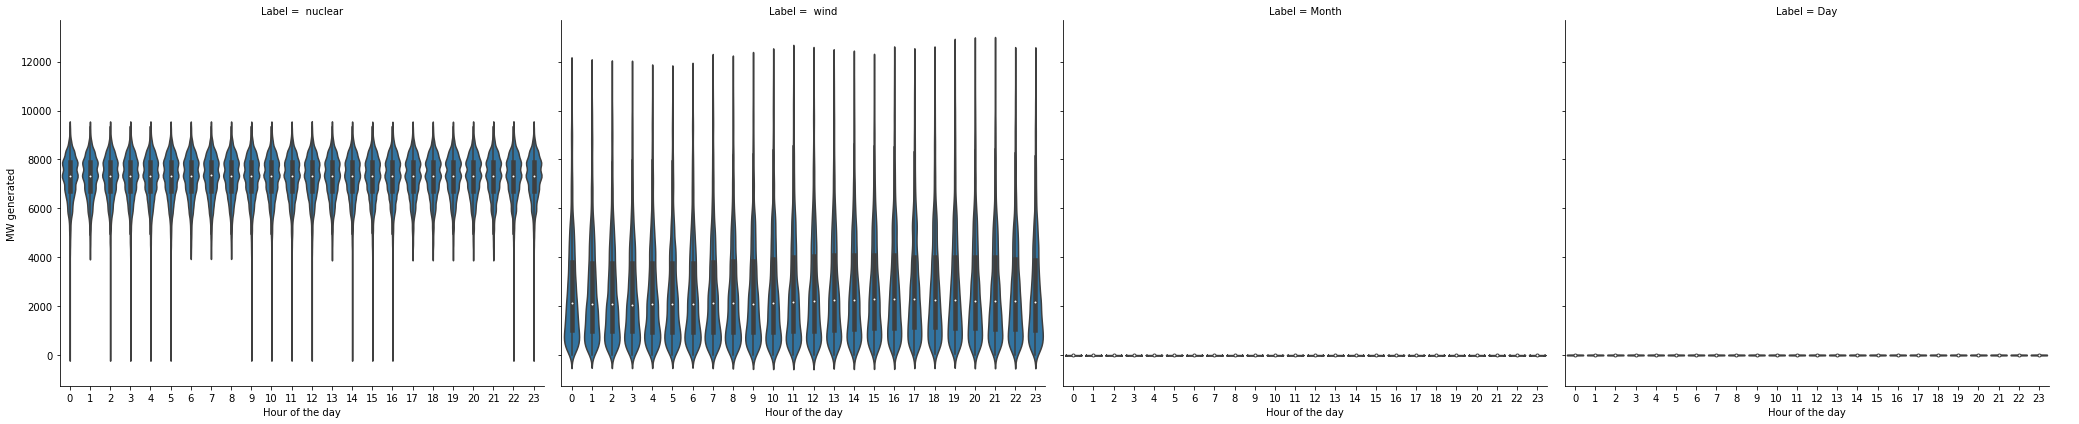

In [24]:
g = sns.FacetGrid(data121melted, col='Label', size=6, aspect=1.2)
g.map(sns.violinplot, "Hour", 'value', alpha=.7)
g.add_legend();
g.set_ylabels('MW generated')
g.set_xlabels('Hour of the day')

So the violin plots don't show much other than the fact that there is more spread in the wind data. There isn't much noticeable variation throughout the day for either nuclear or wind

C:\Users\Chris\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



Text(0.5,0.98,'Nuclear power generation over the years using seaborn: A masterpiece')

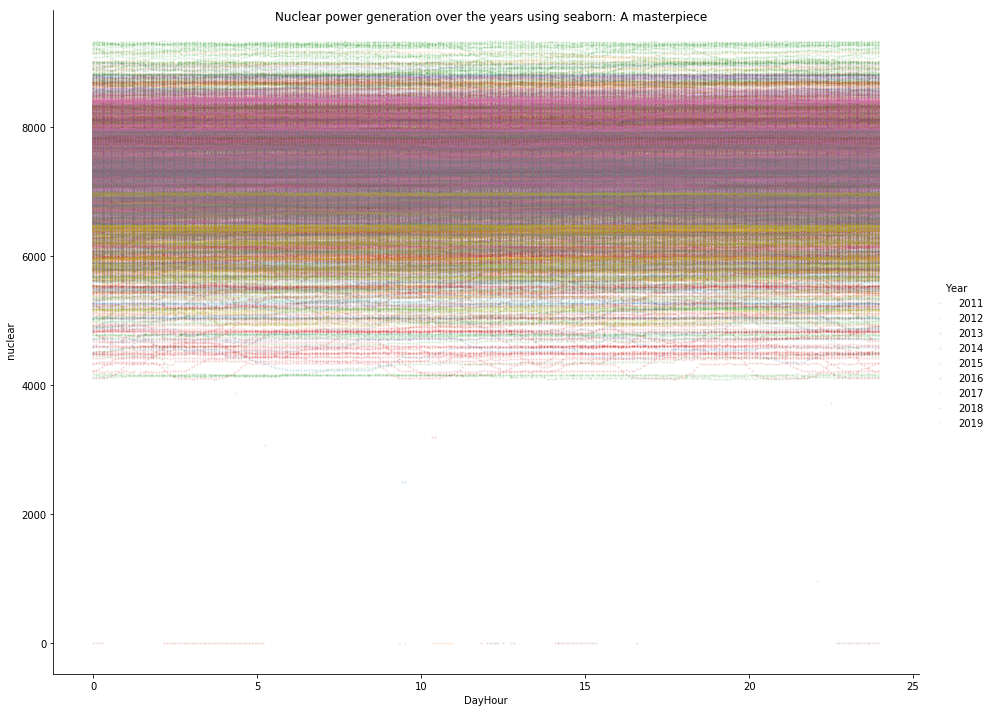

In [25]:
data121chopped = data121.head(100000)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
g = sns.lmplot(data=data121, x='DayHour', y=' nuclear', hue='Year',fit_reg=False,
              scatter_kws={'alpha':0.1, 's':2},size=10, aspect=1.3)
fig = g.fig
fig.suptitle('Nuclear power generation over the years using seaborn: A masterpiece')
#g.add_legend();

Text(0.5,0.98,'Demand using seaborn')

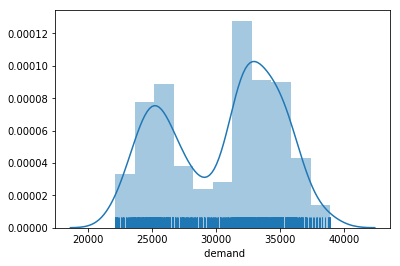

In [26]:
data121chopped = data121.head(100000)
#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
g = sns.distplot(data121.loc[:,' demand'][:1000], rug=True)#,# hue='Year',fit_reg=False,
              #scatter_kws={'alpha':0.1, 's':2},size=10, aspect=1.3)

#fig = g.fig
fig.suptitle('Demand using seaborn')
#g.add_legend();

In [27]:
data121.columns


Index([' timestamp', 'id', ' demand', ' nuclear', ' wind', 'Hour', 'Min',
       'DayHour', 'Year', 'Month', 'Day'],
      dtype='object')

C:\Users\Chris\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



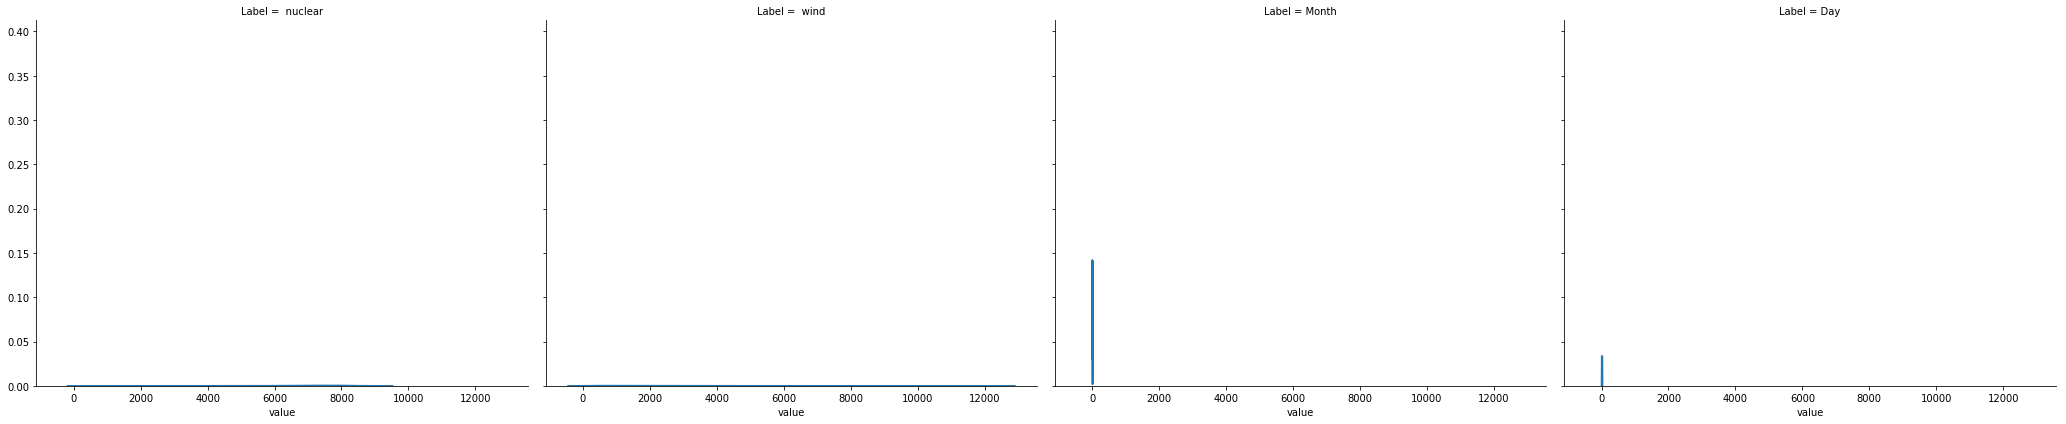

In [28]:
g = sns.FacetGrid(data121melted, col='Label', size=6, aspect=1.2)
g.map(sns.distplot,'value')
#g = sns.distplot(data121[' nuclear'])
#g.add_legend();
#g.set_ylabels('MW generated')
#g.set_xlabels('Hour of the day')

Text(0.5,0.98,'Distribution of nuclear & wind power outputs in 5min intervals')

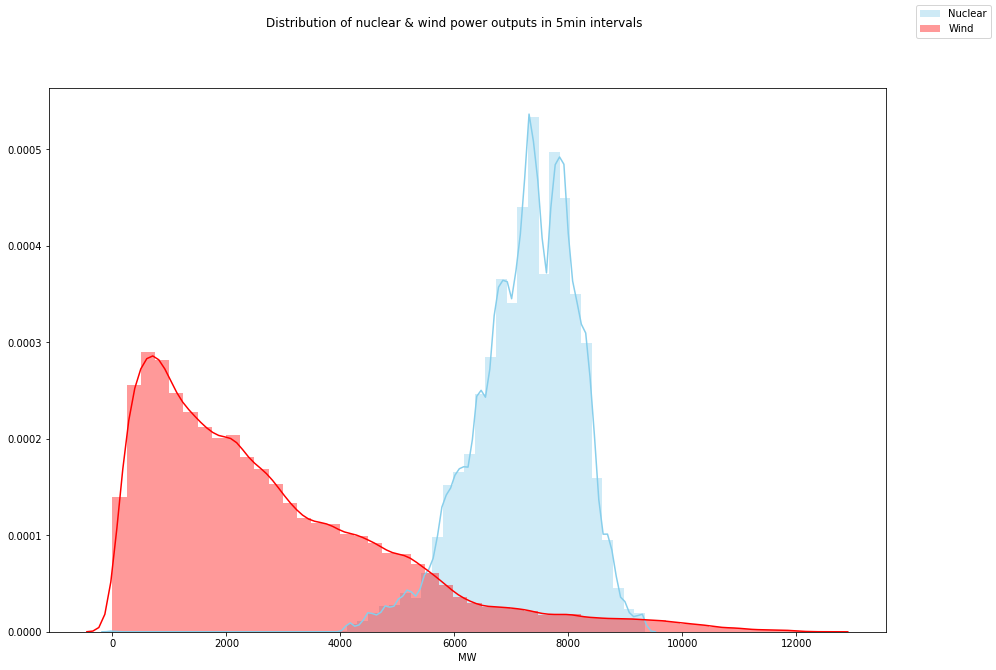

In [29]:
f, axes = plt.subplots(1,1, figsize=(15,10), sharex=True)
g = sns.distplot(data121[' nuclear'], color='skyblue', label='Nuclear')
g = sns.distplot(data121[' wind'], color='red', label='Wind',axlabel='MW')

f.legend()
f.suptitle('Distribution of nuclear & wind power outputs in 5min intervals')
#f.se

In [88]:
#f, axes = plt.subplots(1,1, figsize=(15,10), sharex=True, sharey=True)
y1, m1 = 2018, 3
chosenSpan = data121[(data121['Year']==y1)]# & (data121['Month']==m1)]
#for date in chosenSpan.loc[:,'Day'].unique():
    #g= sns.lineplot(x='DayHour',y=' demand',data=chosenSpan[chosenSpan['Day']==date])#, color='skyblue', label='Demand')

#g.show()

In [89]:
#f, axes = plt.subplots(1,1, figsize=(15,10), sharex=True, sharey=True)
y1, m1 = 2018, 3
chosenSpan = data121[data121['Month']==m1]
#for date in chosenSpan.loc[:,'Day'].unique():
    #g= sns.lineplot(x='DayHour',y=' demand',data=chosenSpan[chosenSpan['Day']==date])#, color='skyblue', label='Demand')

#g.show()

In [90]:
#f, axes = plt.subplots(1,1, figsize=(15,10), sharex=True, sharey=True)
y1, m1 = 2018, 3
chosenSpan = data121#[(data121['Year']==y1)]# & (data121['Month']==m1)]
#for date in chosenSpan.loc[:,'Day'].unique():
   # g= sns.lineplot(x='DayHour',y=' demand',data=chosenSpan[chosenSpan['Day']==date])#, color='skyblue', label='Demand')

#g.show()

In [91]:
#f, axes = plt.subplots(1,1, figsize=(15,10), sharex=True, sharey=True)
y1, m1 = 2018, 3
chosenSpan = data121#[(data121['Year']==y1)]# & (data121['Month']==m1)]
#for date in chosenSpan.loc[:,'Day'].unique():
#    g= sns.lineplot(x='DayHour',y=' demand',data=chosenSpan[chosenSpan['Day']==date], sizes=1)#, color='skyblue', label='Demand')

#g.show()

In [34]:
data121.columns
#data121['Month'].unique()

Index([' timestamp', 'id', ' demand', ' nuclear', ' wind', 'Hour', 'Min',
       'DayHour', 'Year', 'Month', 'Day'],
      dtype='object')

# Tidal lagoon 

In [35]:
startDate = datetime.datetime(2019,3,9)
endDate = datetime.datetime(2019,4,10)
tidaldf = pd.DataFrame({'DateTime':pd.date_range(start=startDate,
                                          end = endDate,
                                          freq='0.5H',
                                         normalize=True)})

hrsIn1yr = 365*24
annualOutputQuoted = 572e9 # GWh
avgPowerQuoted = annualOutputQuoted/hrsIn1yr
avgPowerQuoted
avgPowerExpected = 36e6 # W
offshoreLF = 0.39
onshoreLF = 0.27
offshoreWindCapNeeded = avgPowerExpected / offshoreLF
offshoreWindCapNeeded/1e6
no7MWturbinesNeeded = offshoreWindCapNeeded/7e6 # The three UK offshore wind projects in construction have 7MW turbines - renewableuk.com
no7MWturbinesNeeded
genHrsPerDay = 12
powerWhenGenerating = avgPowerExpected*24/genHrsPerDay
powerWhenGenerating/1e6

72.0

In [36]:
tidaldf['Quantity (MW)'] = np.where((tidaldf.index%12) <(genHrsPerDay/2),
                            powerWhenGenerating/1e6,0)

In [37]:
tidaldf.head()

,DateTime,Quantity (MW)
0,2019-03-09 00:00:00,72.0
1,2019-03-09 00:30:00,72.0
2,2019-03-09 01:00:00,72.0
3,2019-03-09 01:30:00,72.0
4,2019-03-09 02:00:00,72.0


# Wind Data

In [38]:
dudgDict, sherDict, burbDict={},{},{}

for i in range(1,97):
    df = pd.read_csv('windData/B1610 ('+str(i)+').csv',skiprows=1)
    newdf = df.groupby(['SP','Settlement Date']).sum()
    newdf['DateTime'] = pd.date_range(start=newdf.index[0][1],
                                          periods=len(newdf),
                                          freq='0.5H',
                                         normalize=True)
    if df.iloc[0,3][:5] == 'DDGNO':
        dudgDict[str(i)] = newdf
    elif df.iloc[0,3][:5] == 'SHRSO':
        sherDict[str(i)] = newdf
    elif df.iloc[0,3][:5] == 'BRBEO':
        burbDict[str(i)] = newdf
    else:
        print(df.iloc[0,3][:5],'not DDGNO or SHRSO')


dudgdf = pd.concat(dudgDict)
dudgdf.reset_index(inplace=True)
dudgdf.drop('level_0', axis=1, inplace=True)
dudgdf.sort_values(by='DateTime',axis=0, inplace=True)

sherdf = pd.concat(sherDict)
sherdf.reset_index(inplace=True)
sherdf.drop('level_0', axis=1, inplace=True)
sherdf.sort_values(by='DateTime',axis=0, inplace=True)
#sherdf

burbdf = pd.concat(burbDict)
burbdf.reset_index(inplace=True)
burbdf.drop('level_0', axis=1, inplace=True)
burbdf.sort_values(by='DateTime',axis=0, inplace=True)

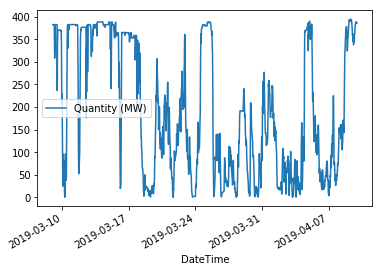

In [39]:
dudgdf.plot(x='DateTime',y='Quantity (MW)')

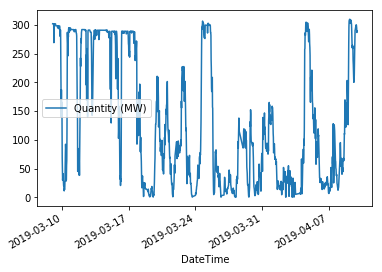

In [40]:
sherdf.plot(x='DateTime',y='Quantity (MW)')

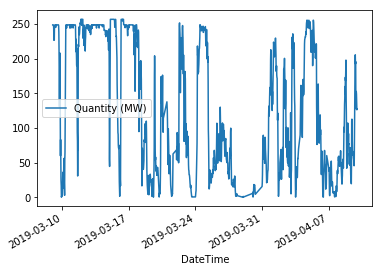

In [41]:
burbdf.plot(x='DateTime',y='Quantity (MW)')

In [42]:
# NEXT - Calculate & Plot tidal output

(0, 414.12)

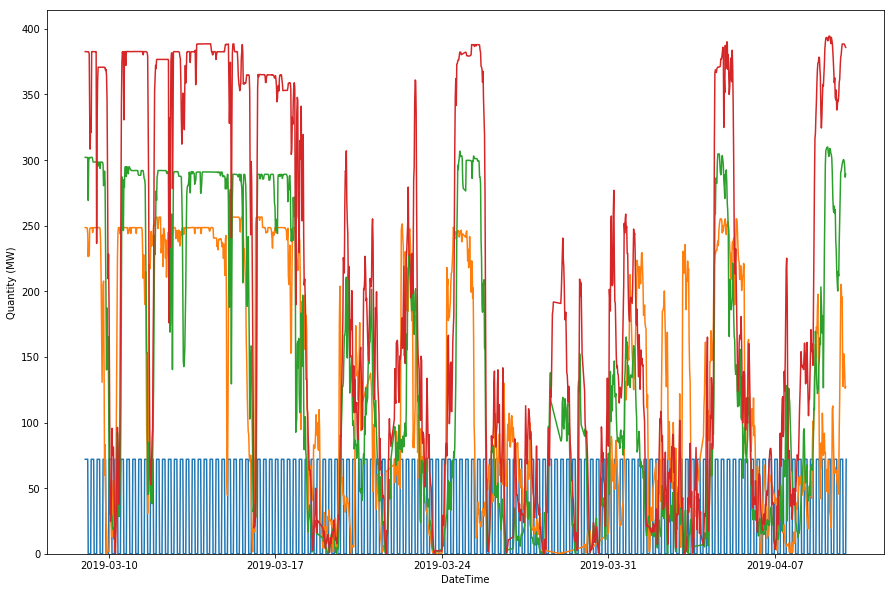

In [43]:
#tidaldf.plot(x='DateTime',y='Power')

f, axes = plt.subplots(1,1, figsize=(15,10), sharex=True, sharey=True)

#for date in chosenSpan.loc[:,'Day'].unique():
g= sns.lineplot(x='DateTime',y='Quantity (MW)',data=tidaldf)#, color='skyblue', label='Demand')
g = sns.lineplot(x='DateTime',y='Quantity (MW)', data=burbdf)
g = sns.lineplot(x='DateTime',y='Quantity (MW)', data=sherdf)
g = sns.lineplot(x='DateTime',y='Quantity (MW)', data=dudgdf)
#g.show()

axes.set_ylim(0,)

In [44]:


def makeDateSubset(df, startDate = startDate, endDate = endDate):
    df1 = df.copy()
    return df1[(df1['DateTime']>startDate) & (df1['DateTime']<=endDate)].copy()

def calcEnergy(df, col = 'Quantity (MW)'):
    ''' Input = whole df.
    Takes subset, adds col and calculates energy in subset '''
    df2 = makeDateSubset(df)
    df2['Energy (GWh)'] = df2[col] * 0.5 * 1e-3
    return df2['Energy (GWh)'].sum()

In [45]:
# Calculate load factor to check workings - should be ~40%

def calcLF(genGWh, installedCapMW, startDate=startDate, endDate=endDate):
    '''genGWh = quantity of energy generated
    installedCapMW = capacity e.g. dudgeon = 402MW'''
    secs = (endDate - startDate).total_seconds() # no of seconds in period
    maxOutputGJ = installedCapMW*secs/1000
    maxOutputGWh = maxOutputGJ/3600
    print(maxOutputGWh)
    return genGWh/maxOutputGWh

print(calcLF(calcEnergy(burbdf),250))

192.0
0.4699870416666667


In [46]:
(endDate - startDate).total_seconds()

2764800.0

(0, 414.12)

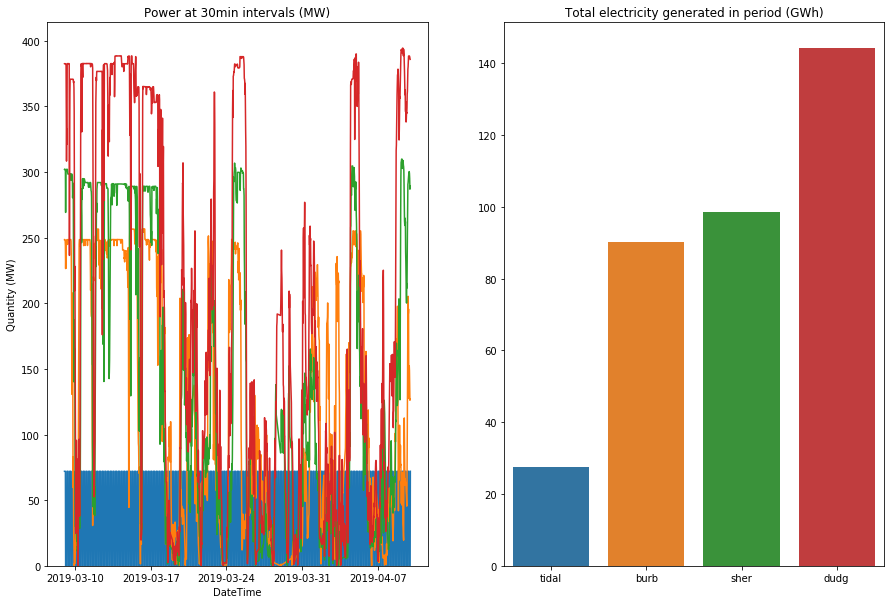

In [47]:
energy = {}
names = ['tidal','burb','sher','dudg']
f, axes = plt.subplots(1,2, figsize=(15,10))#, sharex=True, sharey=True)
z=0

plt.subplot(1,2,1)
for i,df in enumerate([tidaldf,burbdf,sherdf,dudgdf]):
    energy[names[i]]=calcEnergy(df)
    g = sns.lineplot(x='DateTime',y='Quantity (MW)', data=makeDateSubset(df))
bladf = pd.DataFrame(energy, index=['name']).sort_values(by='name',axis=1)    

plt.subplot(1,2,2)
h=sns.barplot(data=bladf)
h.set_title('Total electricity generated in period (GWh)')
g.set_title('Power at 30min intervals (MW)')
g.set_ylim(0,)



In [48]:
dudgdf2 = dudgdf.rename(columns={'Quantity (MW)':'dudg'})
sherdf2 = sherdf.rename(columns={'Quantity (MW)':'sher'})
burbdf2 = burbdf.rename(columns={'Quantity (MW)':'burb'})
tidaldf2 = tidaldf.rename(columns={'Quantity (MW)':'tidal'})
condf = pd.merge(tidaldf2,sherdf2,how='outer',on='DateTime', )
condf.sort_values(by='DateTime',axis=0, inplace=True)
condf = pd.merge(condf,burbdf2, how='outer',on='DateTime')
condf.sort_values(by='DateTime',axis=0, inplace=True)
condf = pd.merge(condf,dudgdf2, how='outer', on='DateTime')
condf.sort_values(by='DateTime',axis=0, inplace=True)
condf.drop(['SP_x', 'Settlement Date_x', 'SP_y','Settlement Date_y', 'SP', 'Settlement Date'],inplace=True,axis=1)



In [49]:
axes[1]

In [50]:
0.2482*30*60

446.76

In [51]:
446.76/3600

0.1241

In [52]:
burbdf.head()

,SP,Settlement Date,Quantity (MW),DateTime
1301,1,2019-03-09,248.472,2019-03-09 00:00:00
1302,2,2019-03-09,248.462,2019-03-09 00:30:00
1303,3,2019-03-09,248.410,2019-03-09 01:00:00
1304,4,2019-03-09,248.452,2019-03-09 01:30:00
1305,5,2019-03-09,248.052,2019-03-09 02:00:00


In [53]:
# Plot demand IN ONE WEEK with Bokeh


#output_file("C:/Users/Chris/Documents/Documents/Python2018/DataVisCW/Plots/tidalLine"+nowtime()+".html")
fig = figure(plot_width=1200, plot_height=600,
             title='Wind plot - Power at 30min intervals, MW',
            x_axis_type='datetime', toolbar_location="above")

dataSource = ColumnDataSource(makeDateSubset(burbdf))

#for colRef,line in enumerate(ylist,1):
lines = fig.line(x='DateTime', y='Quantity (MW)', source=dataSource, 
                 color = Category10[(len(ylist)+2)][colRef],
                line_width=2) 

fig.outline_line_color = None
fig.background_fill_color = "#efefef"

fig.xaxis.formatter = DatetimeTickFormatter(days = [ '%a%e-%b'])
fig.xaxis.minor_tick_line_color = 'black'

#fig.axis.major_tick_line_color = None
fig.axis.axis_line_color = 'black'
#fig.yaxis.axis_label = 'Total electricity supplied in Quarter (TWh)'

output_notebook()




Loading BokehJS ...

In [54]:
def update(s=1,e=10):
    start = datetime.datetime(2019,3,s)
    end = datetime.datetime(2019,4,e)
    dataSource.data.update(ColumnDataSource(data=makeDateSubset(burbdf, startDate=start, endDate=end)).data)
    push_notebook()
    

In [55]:
show(fig, notebook_handle=True)

In [56]:
interact(update, s=(7,28), e=(1,10))

interactive(children=(IntSlider(value=7, description='s', max=28, min=7), IntSlider(value=10, description='e',…

<function __main__.update(s=1, e=10)>

In [81]:
# Plot demand IN ONE WEEK with Bokeh

output_notebook()
#output_file("C:/Users/Chris/Documents/Documents/Python2018/DataVisCW/Plots/tidalLine"+nowtime()+".html")
fig = figure(plot_width=600, plot_height=500,
             title='Power at 30min intervals, MW',
            x_axis_type='datetime', toolbar_location="above")
barfig = figure(plot_width=300, plot_height=500,
             title='Electricity generated in period (GWh)',
             toolbar_location=None,
               x_range=ylist)
ylist=['tidal','dudg','sher','burb']

dataSource = ColumnDataSource(makeDateSubset(condf))

y,colorList= [],[]

for colRef,bar in enumerate(ylist,1):
    y.append(calcEnergy(condf,bar))
    colorList.append(Category10[(len(ylist)+2)][colRef])
    
barDict = dict(x=ylist, top=y, col = colorList)

barDS = ColumnDataSource((barDict))


for colRef,line in enumerate(ylist,1):
    lines = fig.line(x='DateTime', y=line, source=dataSource, 
                 color = Category10[(len(ylist)+2)][colRef],
                line_width=2) 

bars = VBar(x='x', top='top',width=0.5,
            line_color='col',
           fill_color='col')
barfig.add_glyph(barDS, bars)

fig.outline_line_color = None
fig.background_fill_color = "#efefef"

fig.xaxis.formatter = DatetimeTickFormatter(days = [ '%a%e-%b'])
fig.xaxis.minor_tick_line_color = 'black'

#fig.axis.major_tick_line_color = None
fig.axis.axis_line_color = 'black'
fig.y_range.start=0
barfig.y_range.start=0
#fig.yaxis.axis_label = 'Total electricity supplied in Quarter (TWh)'



Loading BokehJS ...

In [82]:
numDays = (endDate-startDate).days
numDays

32

In [83]:
def update(startDay=1,timeRange=10):
    start = startDate + datetime.timedelta(days=startDay)
    #datetime.datetime(2019,3,s)
    end = start + datetime.timedelta(days=timeRange)
    #datetime.datetime(2019,4,e)
    dataSource.data.update(ColumnDataSource(data=makeDateSubset(condf, startDate=start, endDate=end)).data)
    y=[]
    for bar in ylist:
        y.append(calcEnergy(makeDateSubset(condf, startDate=start, endDate=end),bar))
    barDict = dict(x=ylist, top=y,col = colorList)
    barDS.data.update(ColumnDataSource(data=barDict).data)
    push_notebook()
    

In [84]:
show(row(fig,barfig), notebook_handle=True)

In [85]:
interact(update, startDay=(1,numDays-7), timeRange=(7,numDays))

interactive(children=(IntSlider(value=1, description='startDay', max=25, min=1), IntSlider(value=10, descripti…

<function __main__.update(startDay=1, timeRange=10)>

In [62]:
condf[condf['DateTime']>datetime.datetime(2019,3,29,3)]
for col in condf.columns:
    print(col, len(condf[col].unique()))

DateTime 1537
tidal 2
sher 1402
burb 1257
dudg 1433


In [63]:
dataSource.column_names

['index', 'DateTime', 'tidal', 'sher', 'burb', 'dudg']

In [77]:
output_notebook()
x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)
p = figure(title="simple line example", plot_height=300, plot_width=600, y_range=(-5,5),
           background_fill_color='#efefef')
r = p.line(x, y, color="#8888cc", line_width=1.5, alpha=0.8)

Loading BokehJS ...

In [78]:

def update(f, w=1, A=1, phi=0):
    if   f == "sin": func = np.sin
    elif f == "cos": func = np.cos
    r.data_source.data['y'] = A * func(w * x + phi)
    push_notebook()

In [79]:
#show(p, notebook_handle=True)

In [80]:
#interact(update, f=["sin", "cos"], w=(0,50), A=(1,10), phi=(0, 20, 0.1))

In [68]:
#condf = tidaldf.copy()
#condf['dudg'] = dudgdf['Quantity (MW)'].copy()
#condf['sher'] = sherdf['Quantity (MW)'].copy()
#condf['burb'] = burbdf['Quantity (MW)'].copy()
#condf.tail(100)

In [69]:
dudgdf.describe()

,SP,Quantity (MW)
count,1466.000000,1466.000000
mean,24.231241,196.942753
std,13.843755,144.527588
min,1.000000,0.070000
25%,12.000000,58.366500
50%,24.000000,160.995000
75%,36.000000,364.907500
max,48.000000,394.400000


In [70]:
(1537-1347), (1537-1434), (1537-1466)

(190, 103, 71)